In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
from torch.utils.data import Subset
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import segmentation_models_pytorch as smp
from fine_tune import *
from fine_tune_utils import *
from evaluate import *

import time
import json
import random

In [2]:
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# CUDA randomness
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
docs = sorted(os.listdir('models/json_result'))
docs

In [22]:
def inspect_result(filename, metric_list):
    
    """
    Reads model evaluation results from a JSON file and prints the maximum values for specified metrics
    along with the epochs at which these maximum values were recorded.
    
    Args:
        filename (str): The name of the JSON file containing the model results.
                        The file is expected to be in the 'models/json_result/' directory.
        metric_list (list): A list of metric names (str) for which the maximum values will be reported.
    
    Returns:
        None: This function does not return any value. It outputs the maximum values of specified metrics
              directly to the console.
    """

    dirname = os.path.join('models/json_result', filename)
    file = open(dirname)
    model_res = json.load(file)
    print(f'Evaluate {filename}')
    
    for metric in metric_list:
        print(f'Maximum {metric} = {max(model_res[metric])}, Epochs: {list(model_res[metric]).index(max(model_res[metric]))*2}')
    print('')
    

In [23]:
for file in docs:
    inspect_result(file, ['iou', 'f1_micro'])

Evaluate baseline_BCE_1.json
Maximum iou = 0.4467458724975586, Epochs: 30
Maximum f1_micro = 0.6175872087478638, Epochs: 30

Evaluate cifar_BCE_1.json
Maximum iou = 0.41449758410453796, Epochs: 56
Maximum f1_micro = 0.5860704183578491, Epochs: 56

Evaluate pet_BCE_1.json
Maximum iou = 0.41449758410453796, Epochs: 56
Maximum f1_micro = 0.5860704183578491, Epochs: 56



### Load Test Dataset (The same test data will be used to evaluate all models)

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


dataset = OxfordPetsDataset(images_dir='images', masks_dir='annotations/trimaps', transform=transform, mask_transform=mask_transform)
test_indices = load_indices('test_indices.txt')
test_set = Subset(dataset, test_indices)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

test_indices.txt is loaded.


In [10]:
model_lst = sorted(os.listdir('models/model_files'))
model_lst = model_lst[1:]
model_result = []
model_lst

['baseline_BCE_1.pth',
 'baseline_BCE_20.pth',
 'baseline_BCE_50.pth',
 'baseline_BCE_80.pth',
 'cifar_BCE_1.pth',
 'cifar_BCE_1f.pth',
 'cifar_BCE_20.pth',
 'cifar_BCE_50.pth',
 'cifar_BCE_80.pth',
 'pet_BCE_1.pth',
 'pet_BCE_1f.pth',
 'pet_BCE_20.pth',
 'pet_BCE_50.pth',
 'pet_BCE_80.pth']

models/model_files/baseline_BCE_20.pth
Model loaded from checkpoint format.
Evaluate: models/model_files/baseline_BCE_20.pth


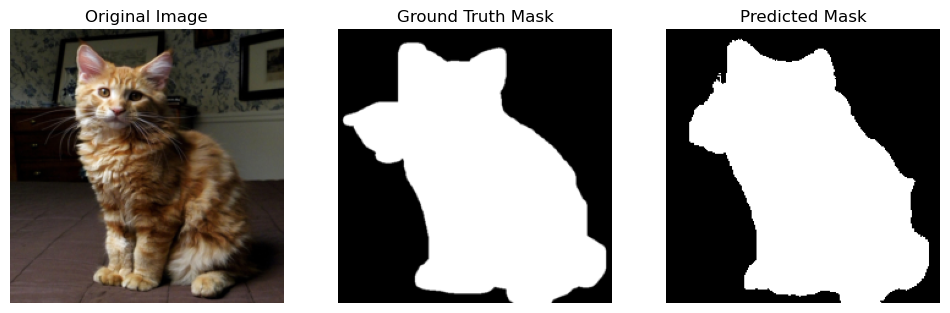

Testing - IoU: 0.7583, F1-score-micro: 0.8624, F1-score-macro: 0.8624, Dice-loss: 0.1497, Focal-loss: 0.2918, BCE-loss: 0.3687, Recall: 0.8672, Accuracy: 0.8925
 
models/model_files/baseline_BCE_50.pth
Model loaded from checkpoint format.
Evaluate: models/model_files/baseline_BCE_50.pth


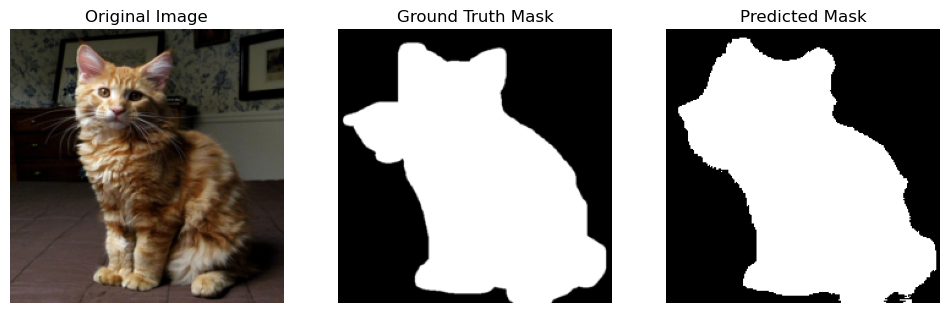

Testing - IoU: 0.8284, F1-score-micro: 0.9060, F1-score-macro: 0.9060, Dice-loss: 0.1097, Focal-loss: 0.1788, BCE-loss: 0.2434, Recall: 0.9041, Accuracy: 0.9247
 
models/model_files/baseline_BCE_80.pth
Model loaded from checkpoint format.
Evaluate: models/model_files/baseline_BCE_80.pth


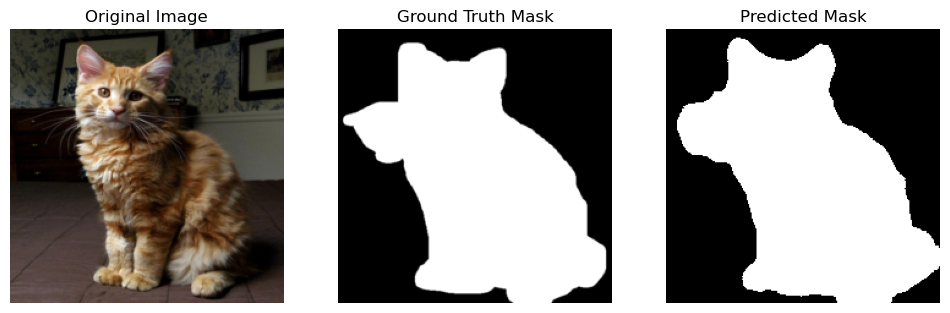

Testing - IoU: 0.9063, F1-score-micro: 0.9507, F1-score-macro: 0.9507, Dice-loss: 0.0598, Focal-loss: 0.1078, BCE-loss: 0.1437, Recall: 0.9422, Accuracy: 0.9607
 
models/model_files/cifar_BCE_20.pth
Model loaded from checkpoint format.
Evaluate: models/model_files/cifar_BCE_20.pth


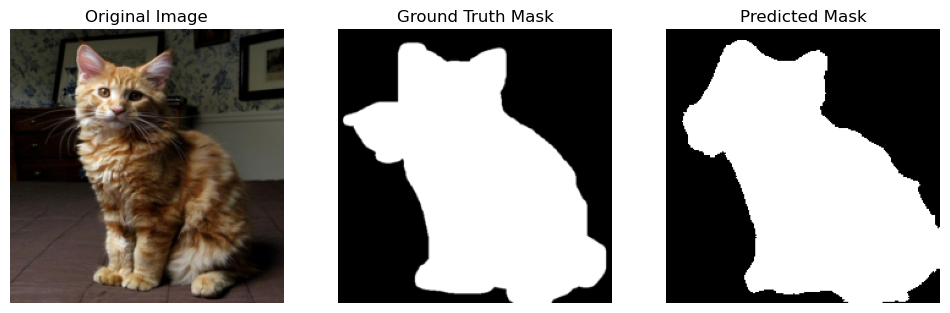

Testing - IoU: 0.7543, F1-score-micro: 0.8598, F1-score-macro: 0.8598, Dice-loss: 0.1503, Focal-loss: 0.3061, BCE-loss: 0.3825, Recall: 0.8712, Accuracy: 0.8899
 
models/model_files/cifar_BCE_50.pth
Model loaded from checkpoint format.
Evaluate: models/model_files/cifar_BCE_50.pth


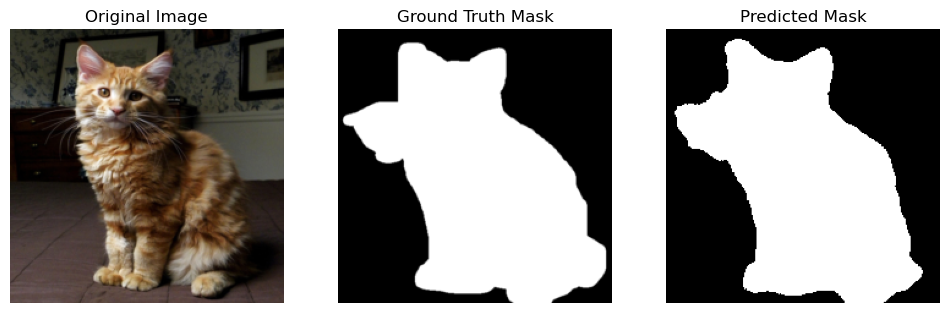

Testing - IoU: 0.8524, F1-score-micro: 0.9201, F1-score-macro: 0.9201, Dice-loss: 0.0906, Focal-loss: 0.2143, BCE-loss: 0.2609, Recall: 0.9030, Accuracy: 0.9354
 
models/model_files/cifar_BCE_80.pth
Model loaded from checkpoint format.
Evaluate: models/model_files/cifar_BCE_80.pth


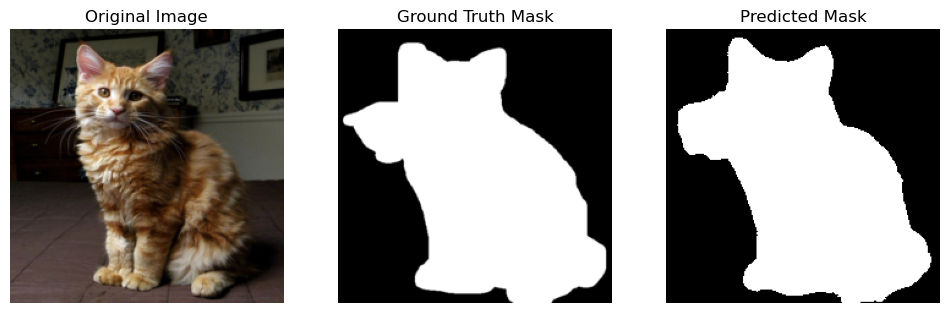

Testing - IoU: 0.9000, F1-score-micro: 0.9472, F1-score-macro: 0.9472, Dice-loss: 0.0656, Focal-loss: 0.1095, BCE-loss: 0.1491, Recall: 0.9373, Accuracy: 0.9583
 
models/model_files/pet_BCE_20.pth
Model loaded from checkpoint format.
Evaluate: models/model_files/pet_BCE_20.pth


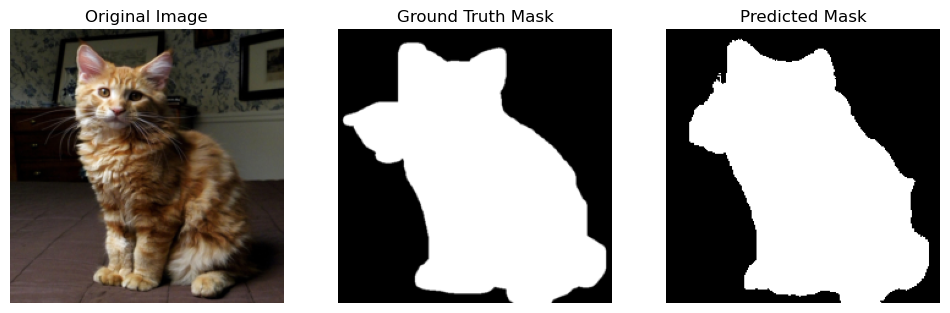

Testing - IoU: 0.7592, F1-score-micro: 0.8629, F1-score-macro: 0.8629, Dice-loss: 0.1480, Focal-loss: 0.2946, BCE-loss: 0.3710, Recall: 0.8671, Accuracy: 0.8916
 
models/model_files/pet_BCE_50.pth
Model loaded from checkpoint format.
Evaluate: models/model_files/pet_BCE_50.pth


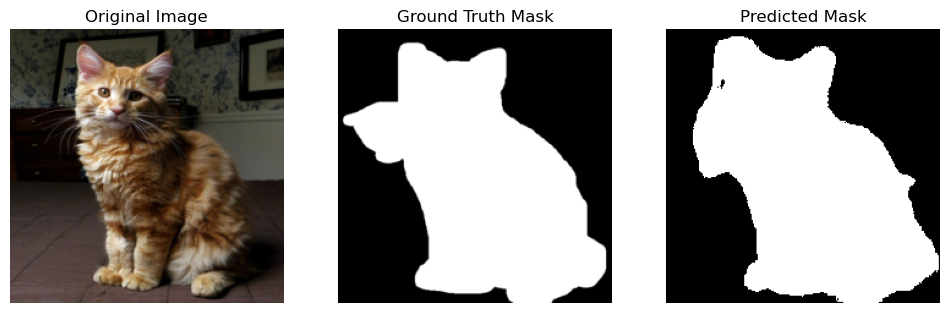

Testing - IoU: 0.8428, F1-score-micro: 0.9146, F1-score-macro: 0.9146, Dice-loss: 0.0988, Focal-loss: 0.1835, BCE-loss: 0.2394, Recall: 0.9086, Accuracy: 0.9315
 
models/model_files/pet_BCE_80.pth
Model loaded from checkpoint format.
Evaluate: models/model_files/pet_BCE_80.pth


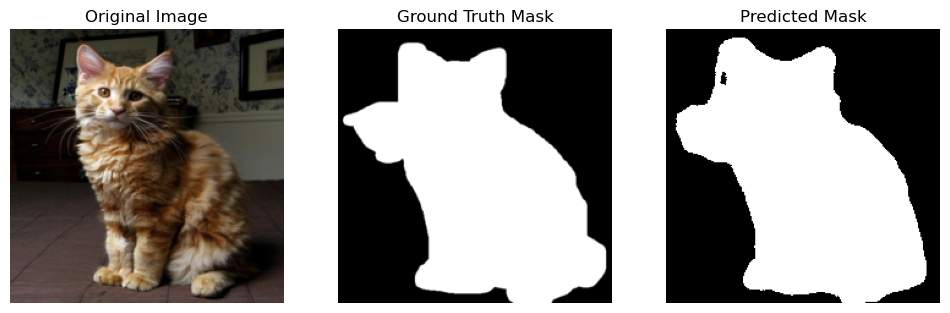

Testing - IoU: 0.9020, F1-score-micro: 0.9484, F1-score-macro: 0.9484, Dice-loss: 0.0636, Focal-loss: 0.1296, BCE-loss: 0.1668, Recall: 0.9287, Accuracy: 0.9582
 


In [40]:
for i in range(len(model_lst)):
    model_name, loss_func, dev_split = model_lst[i].split('.')[0].split('_')
    dirname = os.path.join(f'models/model_files', model_lst[i])
    print(dirname)
    model = load_model(dirname)
    model.eval()
    mean_iou, mean_fscore_micro, mean_fscore_macro, mean_dice, mean_focal, mean_bce, mean_recall, mean_accuracy = evaluate_model(model, test_loader, device, message = dirname)

    model_result.append([model_name, loss_func, dev_split, mean_iou, mean_fscore_macro, mean_dice, mean_focal, mean_bce, mean_recall, mean_accuracy])

In [55]:
df = pd.DataFrame(model_result, columns = ['model', 'loss_func', 'dev_split', 'iou', 'f1', 'dice', 'focal', 'BCE', 'recall', 'accuracy'])
# df.to_csv('model_result_v2.csv')
df

,model,loss_func,dev_split,iou,f1,dice,focal,BCE,recall,accuracy
0,baseline,BCE,20,0.758334,0.862420,0.149655,0.291831,0.368651,0.867204,0.892502
1,baseline,BCE,50,0.828430,0.906025,0.109664,0.178850,0.243388,0.904139,0.924721
2,baseline,BCE,80,0.906298,0.950731,0.059808,0.107837,0.143672,0.942204,0.960704
3,cifar,BCE,20,0.754270,0.859762,0.150256,0.306093,0.382549,0.871233,0.889909
4,cifar,BCE,50,0.852374,0.920138,0.090562,0.214276,0.260893,0.903036,0.935366
5,cifar,BCE,80,0.899981,0.947219,0.065570,0.109452,0.149123,0.937303,0.958341
6,pet,BCE,20,0.759178,0.862902,0.148040,0.294553,0.371025,0.867119,0.891649
7,pet,BCE,50,0.842847,0.914607,0.098845,0.183518,0.239422,0.908605,0.931519
8,pet,BCE,80,0.901966,0.948375,0.063582,0.129628,0.166829,0.928745,0.958239
